In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
from adefc_vortex import adefc_2dm as adefc
import adefc_vortex.pwp as pwp
import adefc_vortex.fresnel_2dm as fresnel
import adefc_vortex.fraunhofer_2dm as fraunhofer



/home/kianmilani/Projects/adefc-vortex/adefc_vortex


/home/kianmilani/Projects/adefc-vortex/adefc_vortex


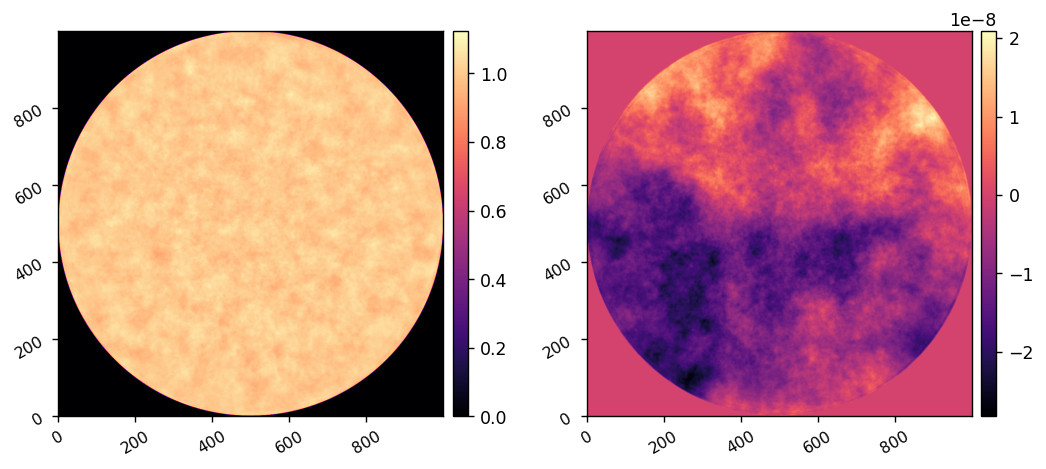

In [2]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

/home/kianmilani/Projects/adefc-vortex/adefc_vortex


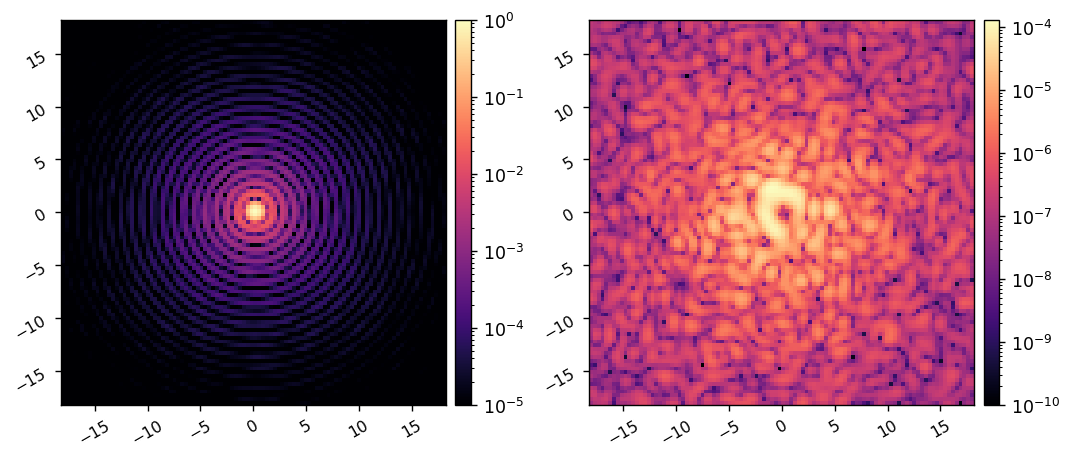

In [3]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow2(ref_psf, ref_coro_im,
        pxscl=I.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)


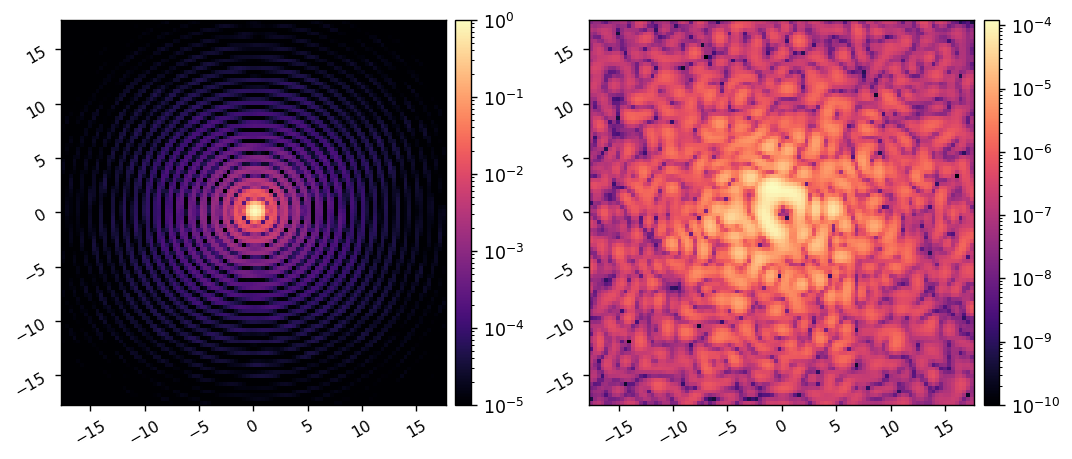

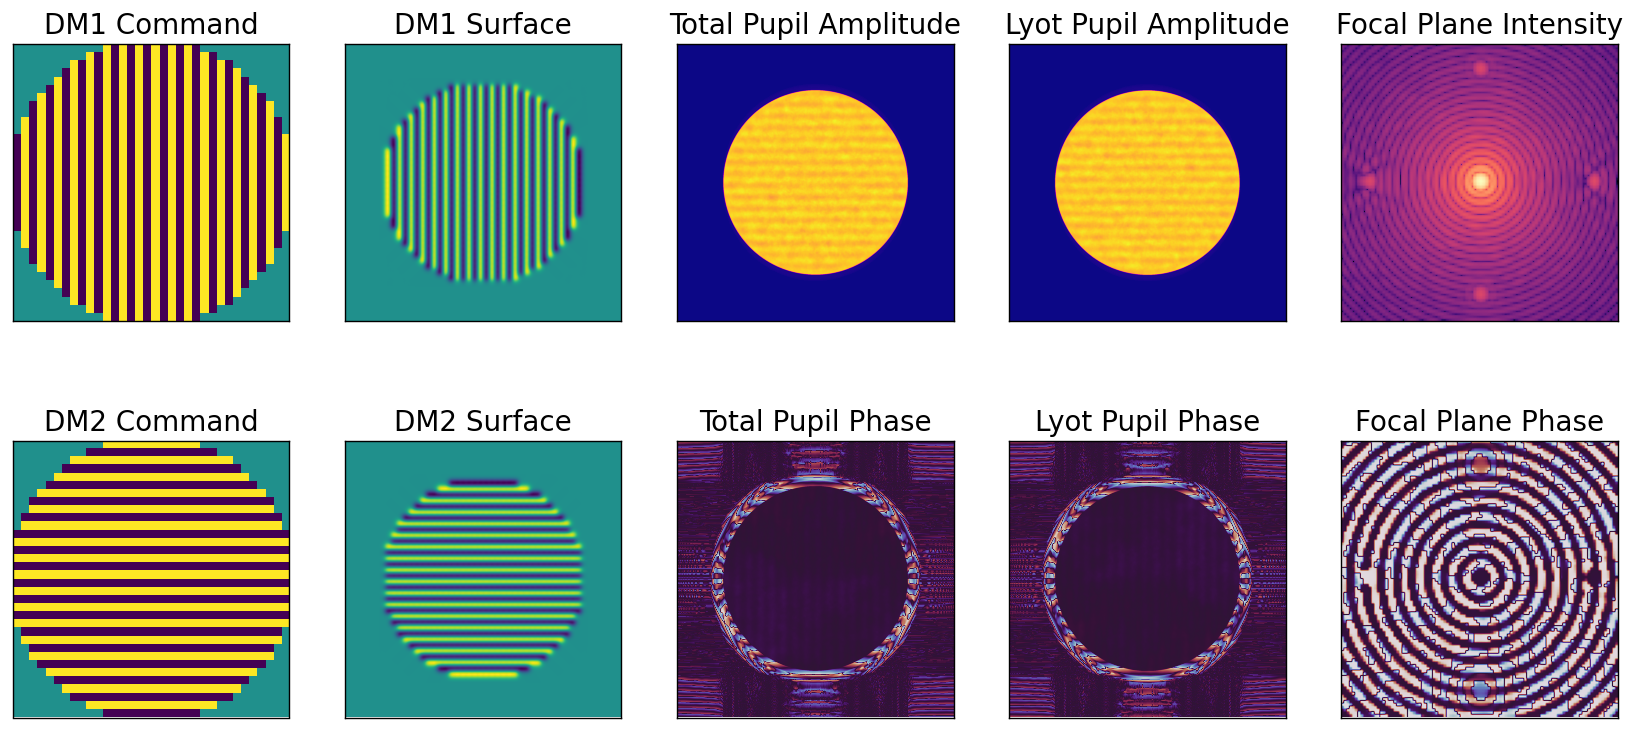

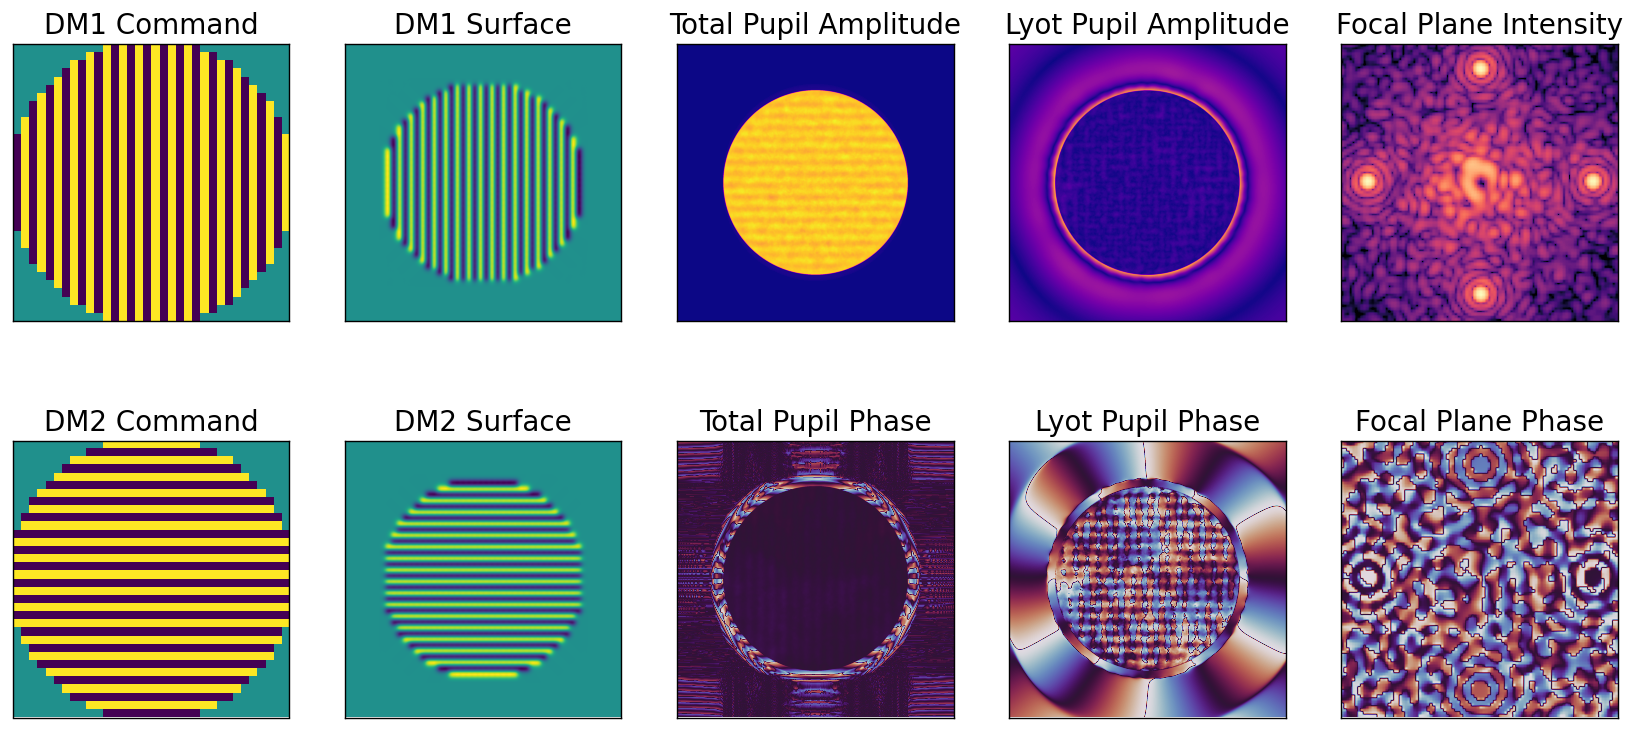

In [8]:
reload(fraunhofer)
M = fraunhofer.MODEL()
M.AMP = AMP
M.OPD = OPD

M.flip_dm = True
M.flip_lyot = True

M.setattr('use_vortex', False)
model_psf = xp.abs(M.calc_wf())**2
M.setattr('Imax_ref', xp.max(model_psf))
model_psf /= M.Imax_ref

M.setattr('use_vortex', True)
model_coro_im = xp.abs(M.calc_wf())**2

imshow2(model_psf, model_coro_im,
        pxscl=M.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)

dm1_command, dm2_command = ( xp.zeros((M.Nact, M.Nact)), xp.zeros((M.Nact, M.Nact)) )
# command = 50e-9*utils.make_f(h=10, w=6, shift=(0,0))
dm1_command = 2.5e-9*utils.make_fourier_command(x_cpa=17, y_cpa=0)
dm2_command = 2.5e-9*utils.make_fourier_command(x_cpa=0, y_cpa=17)

acts = xp.concatenate([dm1_command[M.dm_mask], dm2_command[M.dm_mask]])
fpwf = M.forward(acts, M.wavelength_c, use_vortex=0, fancy_plot=1)
fpwf = M.forward(acts, M.wavelength_c, use_vortex=1, fancy_plot=1)

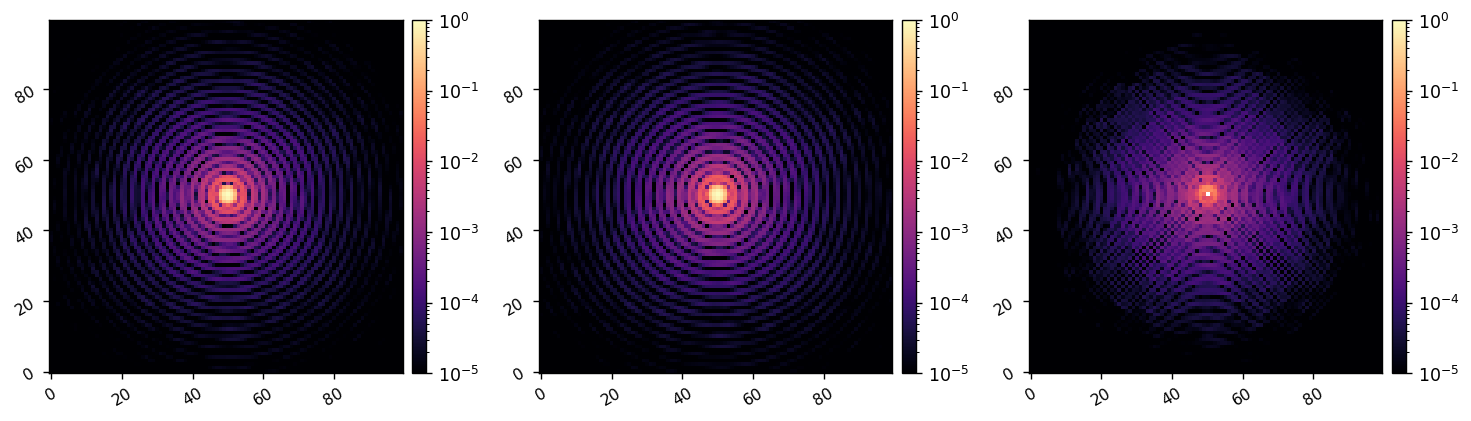

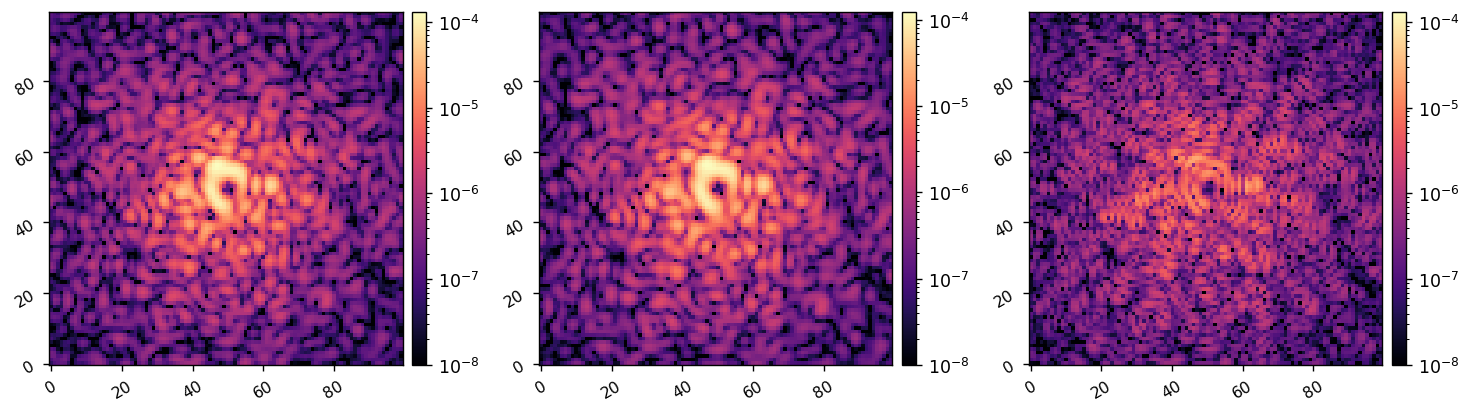

In [9]:
imshow3(ref_psf, model_psf, xp.abs(ref_psf - model_psf), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=1, 
        vmin1=1e-5, vmin2=1e-5, vmin3=1e-5)

imshow3(ref_coro_im, model_coro_im, xp.abs(ref_coro_im - model_coro_im), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=xp.max(ref_coro_im), 
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8)

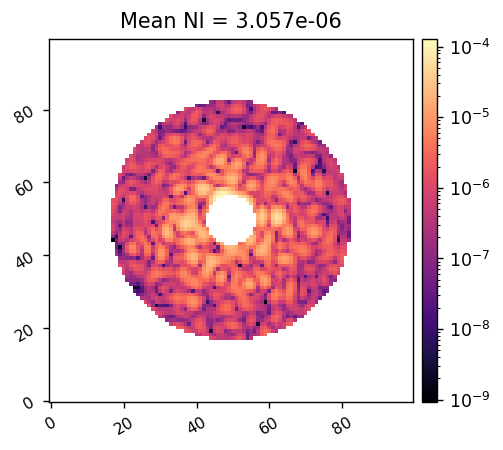

In [17]:
reload(utils)
I.zero_dms()
iwa = 2.5
owa = 12
rot = 0
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=None, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {mean_ni:.3e}', lognorm=True)


	Cost-function J_delE: 0.010
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.010
	Total cost-function value: 1.000



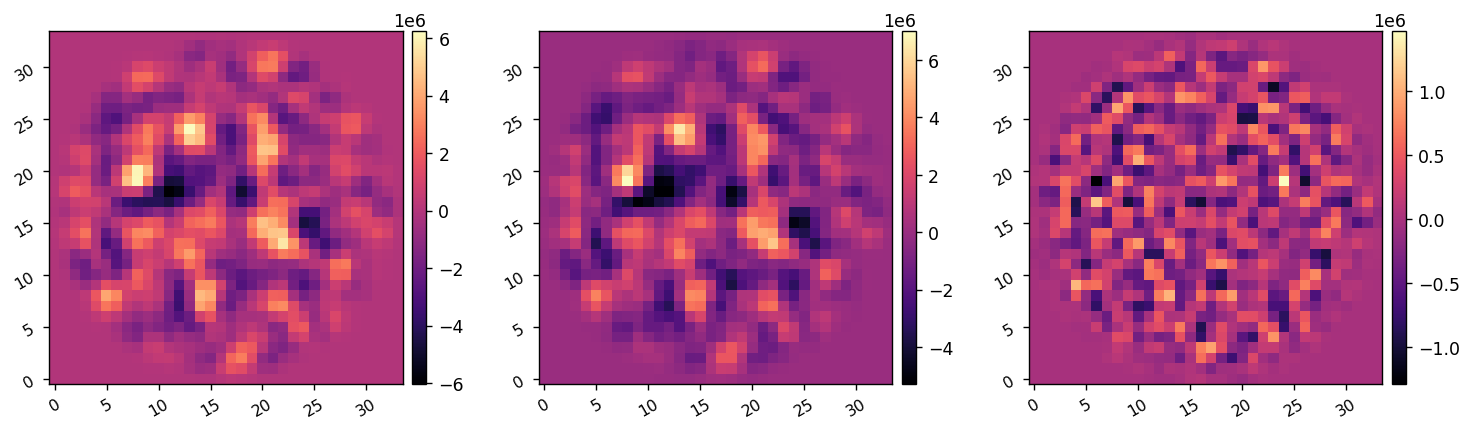

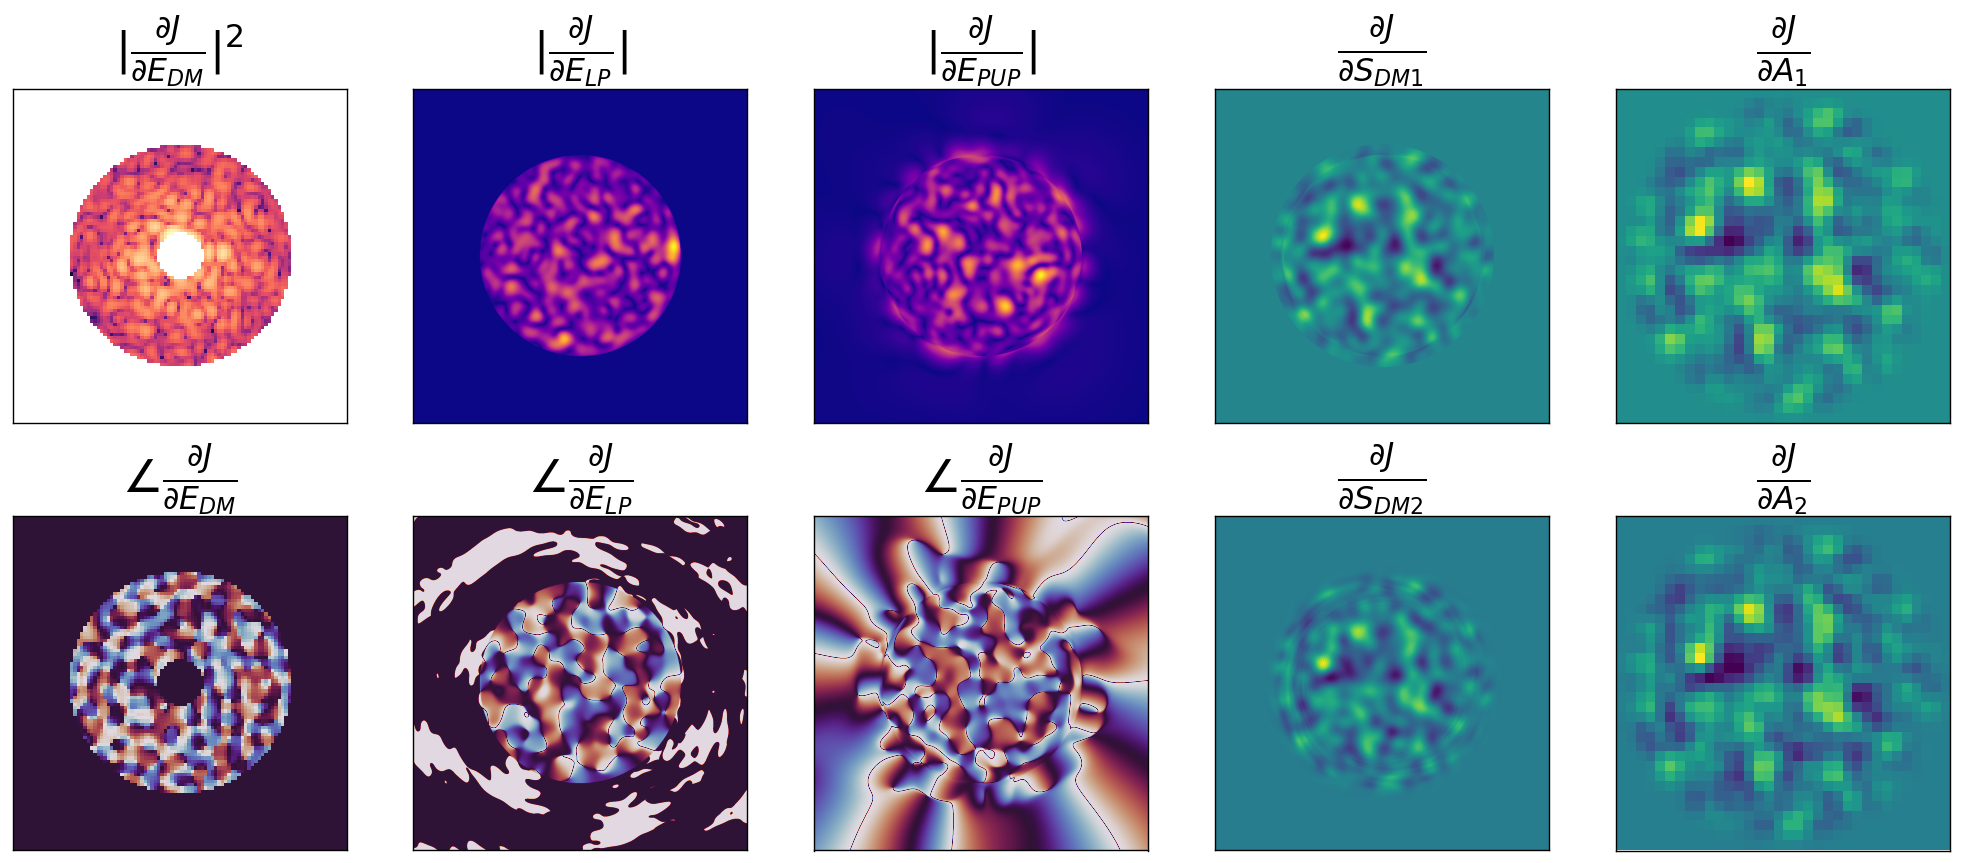

In [ ]:
reload(fraunhofer)
current_acts = xp.zeros(M.Nacts)
# current_acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm1(fraunhofer.acts_to_command(current_acts[:M.Nacts//2], M.dm_mask))
I.set_dm2(fraunhofer.acts_to_command(current_acts[M.Nacts//2:], M.dm_mask))
E_ab = I.calc_wf() * control_mask

E_FP_nom, E_EP, E_DM2P, DM1_PHASOR, DM2_PHASOR = M.forward(current_acts, I.wavelength, use_vortex=True, return_ints=True,)

rmad_vars = { 
    'current_acts':current_acts,
    'E_ab':E_ab, 
    'E_FP_nom':E_FP_nom,
    'E_EP':E_EP,
    'E_DM2P':E_DM2P,
    'DM1_PHASOR':DM1_PHASOR,
    'DM2_PHASOR':DM2_PHASOR,
    'control_mask':control_mask,
    'wavelength':I.wavelength,
    'r_cond':1e-3,
}

del_acts = np.zeros(M.Nacts)
J, dJ_dA = fraunhofer.val_and_grad(
    del_acts, 
    M, 
    rmad_vars,
    verbose=True, 
    # plot=True, 
    fancy_plot=True,
)

dm1_grad = fraunhofer.acts_to_command(dJ_dA[:M.Nacts//2], M.dm_mask)
dm2_grad = fraunhofer.acts_to_command(dJ_dA[M.Nacts//2:], M.dm_mask)
imshow3(dm1_grad, dm2_grad, dm2_grad-dm1_grad)

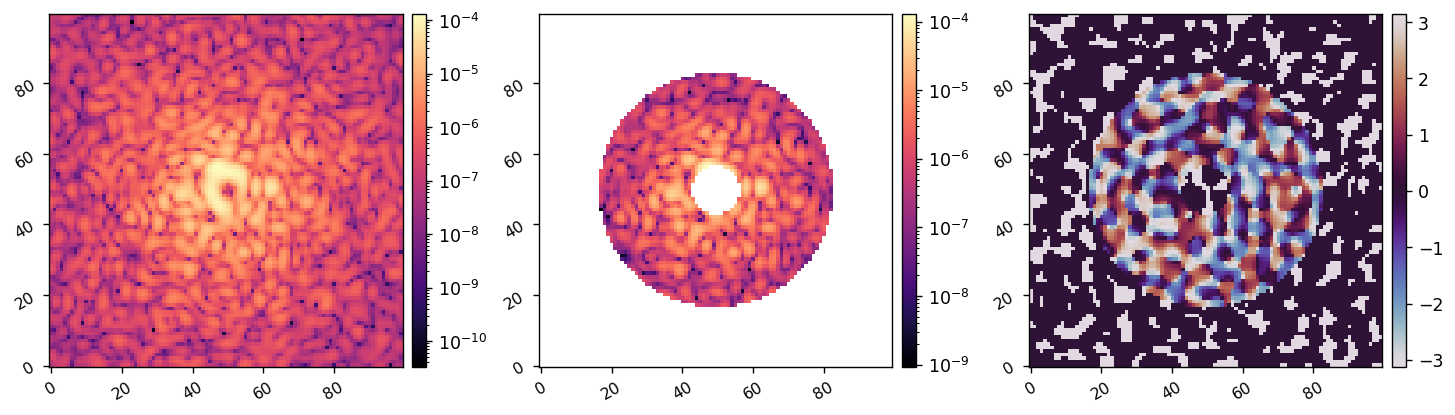

	Cost-function J_delE: 0.010
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.010
	Total cost-function value: 1.000

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  7.00527D+06
	Cost-function J_delE: 0.001
	Cost-function J_c: 2366863905.325
	Cost-function normalization factor: 0.010
	Total cost-function value: 235458128939.368



 This problem is unconstrained.


	Cost-function J_delE: 0.027
	Cost-function J_c: 5.870
	Cost-function normalization factor: 0.010
	Total cost-function value: 586.627

	Cost-function J_delE: 0.717
	Cost-function J_c: 0.374
	Cost-function normalization factor: 0.010
	Total cost-function value: 108.503

	Cost-function J_delE: 3.794
	Cost-function J_c: 0.024
	Cost-function normalization factor: 0.010
	Total cost-function value: 379.778

	Cost-function J_delE: 0.840
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.010
	Total cost-function value: 83.606

	Cost-function J_delE: 0.003
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.010
	Total cost-function value: 0.287


At iterate    1    f=  2.86778D-01    |proj g|=  1.99956D+06
	Cost-function J_delE: 0.002
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.010
	Total cost-function value: 0.170


At iterate    2    f=  1.70142D-01    |proj g|=  1.07483D+06
	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function n

In [ ]:
reload(fraunhofer)

current_acts = xp.zeros(M.Nacts)
# current_acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm1(fraunhofer.acts_to_command(current_acts[:M.Nacts//2], M.dm_mask))
I.set_dm2(fraunhofer.acts_to_command(current_acts[M.Nacts//2:], M.dm_mask))
E_ab = I.calc_wf() * control_mask
E_FP_nom, E_EP, E_DM2P, DM1_PHASOR, DM2_PHASOR = M.forward(current_acts, I.wavelength, use_vortex=True, return_ints=True,)

rmad_vars = { 
    'current_acts':current_acts,
    'E_ab':E_ab, 
    'E_FP_nom':E_FP_nom,
    'E_EP':E_EP,
    'E_DM2P':E_DM2P,
    'DM1_PHASOR':DM1_PHASOR,
    'DM2_PHASOR':DM2_PHASOR,
    'control_mask':control_mask,
    'wavelength':I.wavelength,
    'r_cond':1e-3,
}

bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'maxls':50,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(
    fraunhofer.val_and_grad, 
    jac=True, 
    x0=del_acts0,
    args=(M, rmad_vars, True, False), 
    method='L-BFGS-B',
    tol=bfgs_tol,
    options=bfgs_opts,
)


3.0572277239587807e-06 3.249811194492391e-08


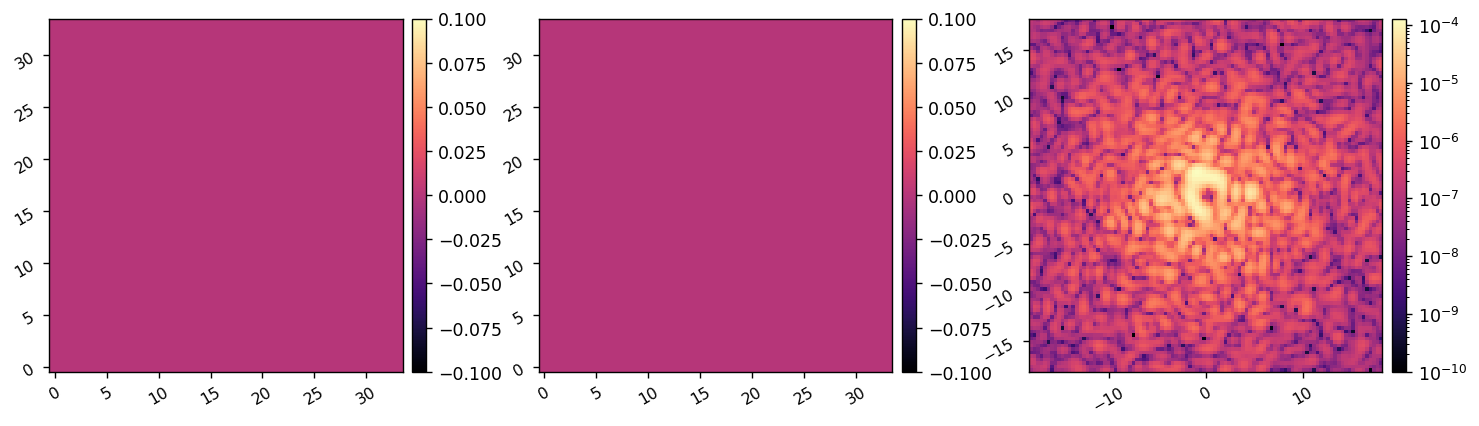

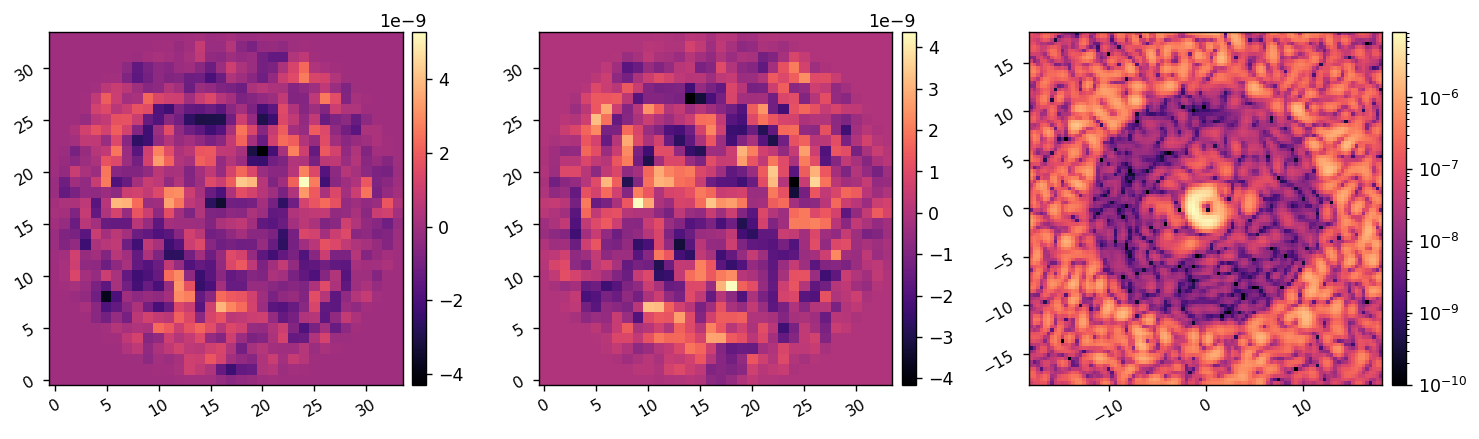

In [23]:
old_dm1 = fraunhofer.acts_to_command(current_acts[:M.Nacts//2], I.dm_mask)
old_dm2 = fraunhofer.acts_to_command(current_acts[M.Nacts//2:], I.dm_mask)
del_dm1 = fraunhofer.acts_to_command(res.x[:M.Nacts//2], I.dm_mask)
del_dm2 = fraunhofer.acts_to_command(res.x[M.Nacts//2:], I.dm_mask)

I.set_dm1(old_dm1)
I.set_dm2(old_dm2)
old_im = I.snap()

I.set_dm1(old_dm1 + del_dm1)
I.set_dm2(old_dm2 + del_dm2)
new_im = I.snap()

print(xp.mean(old_im[control_mask]), xp.mean(new_im[control_mask]))
imshow3(old_dm1, old_dm2, coro_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)
imshow3(del_dm1, del_dm2, new_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)

In [18]:
utils.save_fits('ad_test_acts.fits', res.x)

Saved data to:  ad_test_acts.fits


In [24]:
I.zero_dms()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'dm1_commands':[],
    'del_dm1_commands':[],
    'dm2_commands':[],
    'del_dm2_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

Running estimation algorithm ...
Computing EFC command with L-BFGS


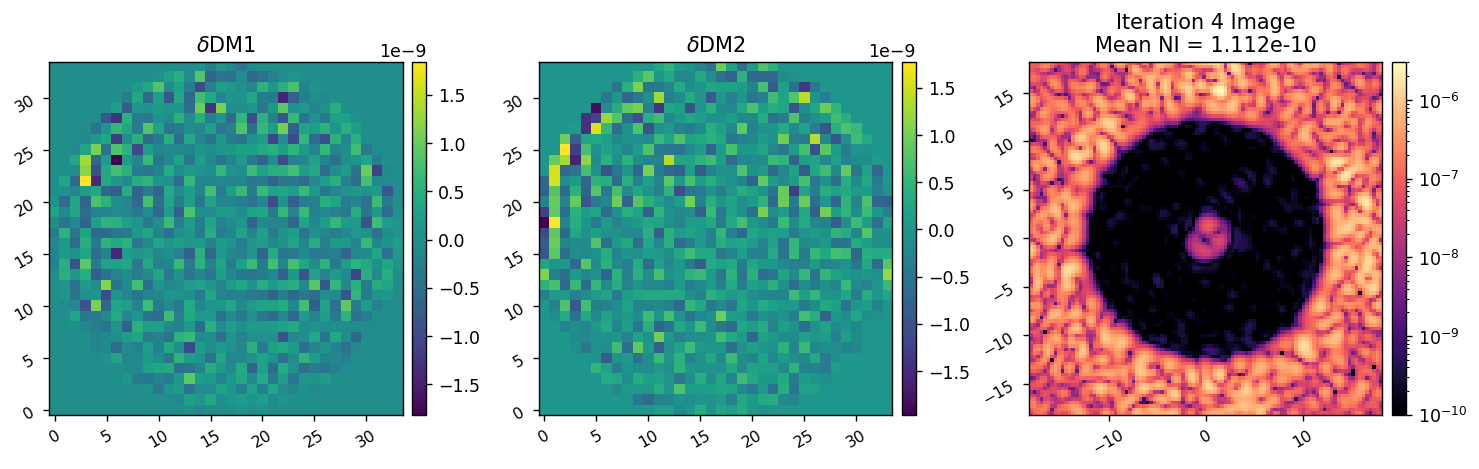

Running estimation algorithm ...
Computing EFC command with L-BFGS


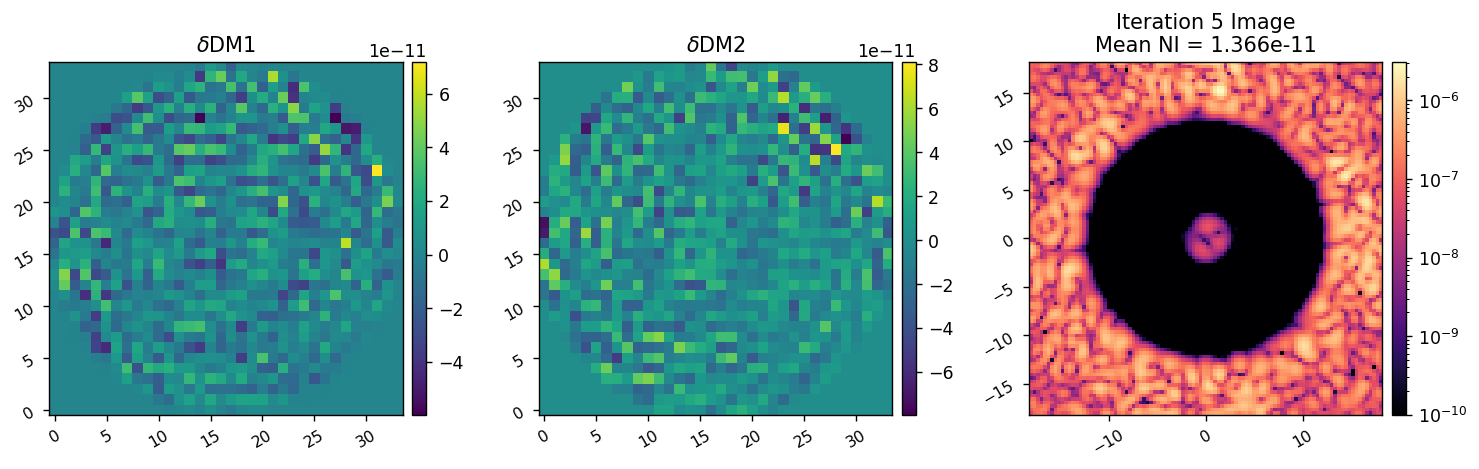

Running estimation algorithm ...
Computing EFC command with L-BFGS


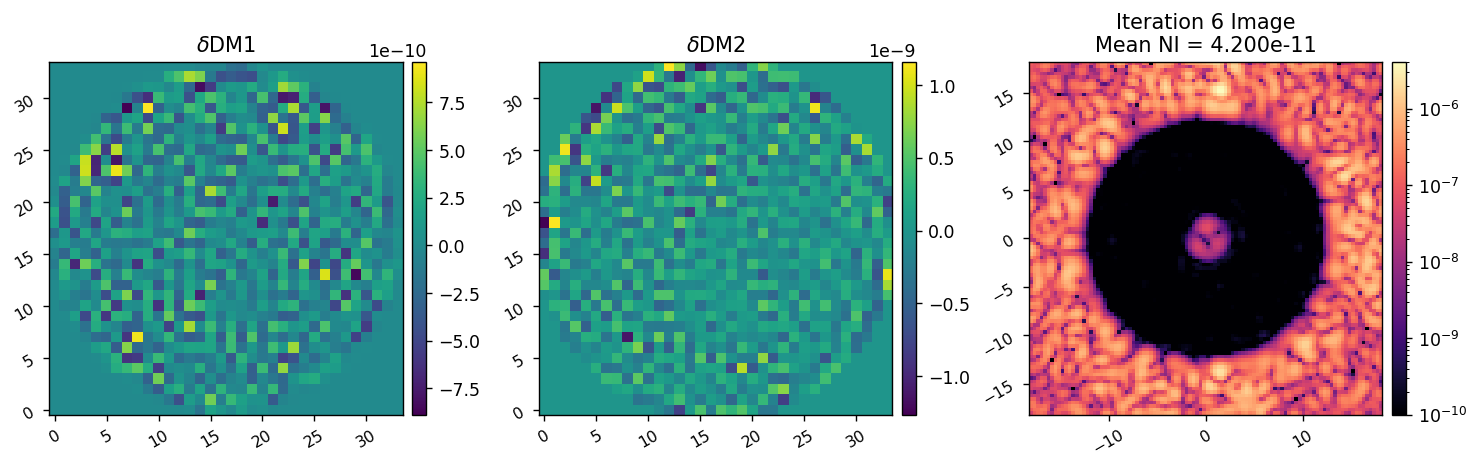

In [28]:
reload(fraunhofer)
reload(adefc)

r_cond = 1e-2
r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
r_cond = 1e-6

bfgs_tol = 1e-2
bfgs_tol = 1e-3
bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':0,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

data = adefc.run(
    I, 
    M, 
    fraunhofer.val_and_grad, 
    control_mask, 
    data,
    Nitr=3, 
    reg_cond=r_cond,
    bfgs_tol=bfgs_tol,
    bfgs_opts=bfgs_opts,
    gain=1,
)

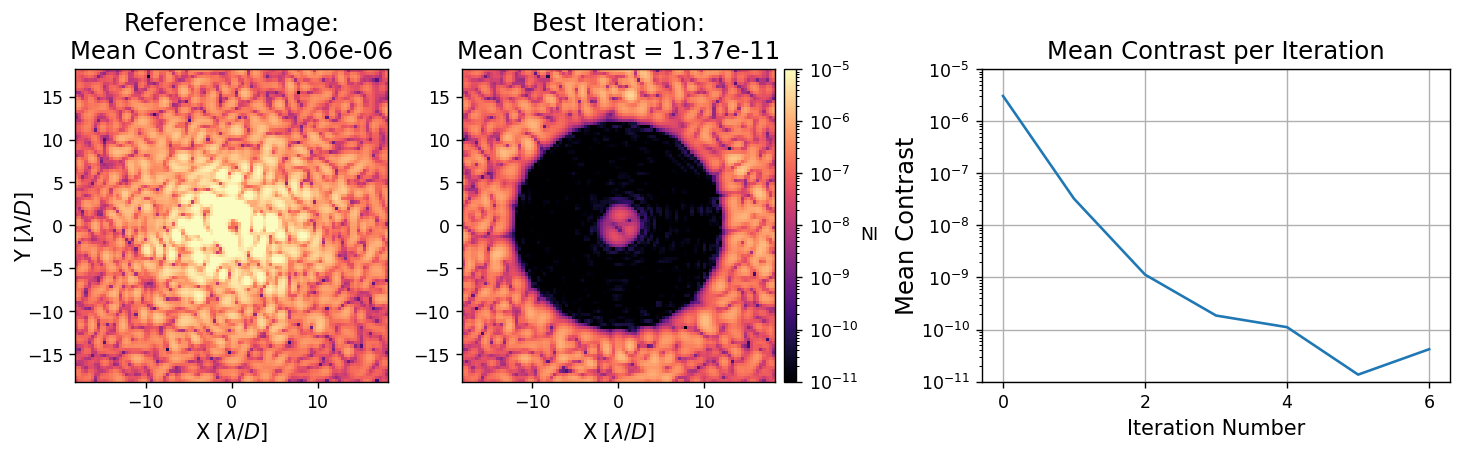

In [29]:
from adefc_vortex.imshows import plot_data
plot_data(data, vmin=1e-11, vmax=1e-5)
